## Packages Installation




In [1]:
%%capture
!pip install pyspark==3.5.0
!pip install gdown

## Setting Flags

In [2]:
preprocessing_pending = False

## Imports

In [104]:
import os
import gdown
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from pyspark import SparkContext, StorageLevel
from pyspark.ml import Pipeline
from pyspark.ml.classification import (GBTClassifier, LogisticRegression,
                                       RandomForestClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import (IndexToString, StringIndexer, VectorAssembler,
                                VectorIndexer)
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.tree import RandomForest
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

## Downloading Raw Data

The dataset consists of incidents of crime reported in the city of Chicago from 2001 to 2019. Data is extracted from the Chicago Police Department's **CLEAR** (Citizen Law Enforcement Analysis and Reporting) system.

**Link:** https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

Downloading the data directly from source link is pretty slow. That's why data is download one time from the source link  and stored in google drive after compression. This was a manual step.

In [4]:
if preprocessing_pending:
  drive.mount('/content/drive')

In [5]:
data_link = 'https://drive.google.com/u/0/uc?id=1wRGDX25AyYWw2eA771CCbvugxYrRQOtw'

In [6]:
compressed_file_path = '/content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv.zip'
!mkdir -p /content/drive/MyDrive/CrimeInsightsRawData

Downloading raw compressed data from google drive and uncompressing it in case of pending preprocessing

In [7]:
%%capture
if preprocessing_pending:
  gdown.download(data_link,compressed_file_path)
  os.system("""unzip -o /content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv.zip -d /content/drive/MyDrive/CrimeInsightsRawData/""")

In [8]:
file_path = '/content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv'

## Data Preprocessing & Transformations

Set up the configuration for our Spark application.
- SparkContext allows us to connect to a Spark cluster.  
- Spark Session which allows us to work with structured data using DataFrames and Datasets.

In [9]:
spark = SparkSession.builder.appName("CrimeInsights")\
.config("spark.driver.memory", "10g")\
.getOrCreate()

**Defining the schema on how we will structure our DataFrame**


*   The column name as a string
*   The data type of the column
*   A Boolean value indicating that null values are allowed in the column.






In [10]:
schema = StructType([StructField("ID", IntegerType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", IntegerType(), True),
                            StructField("Community Area", IntegerType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

Read the CSV file, applies the schema and stores the data in a DataFrame if preprocessing is pending



In [11]:
if preprocessing_pending:
  df = spark.read.csv(file_path,header=True,schema=schema)
  df.show()

Casting date column to timestamp type

In [12]:
if preprocessing_pending:
  casted_df = df.withColumn('Date',to_timestamp(col('date'),'MM/dd/yyyy hh:mm:ss a'))
  casted_df.show()

Storing data in parquet format for faster processing only doing it in case of pending preprocessing

In [13]:
parquet_path = '/content/drive/MyDrive/CrimeInsightParquet/'

In [14]:
if preprocessing_pending:
  casted_df.write.parquet(parquet_path,mode='overwrite')

In [15]:
if preprocessing_pending:
  parqued_df = spark.read.parquet(parquet_path)
  parqued_df.printSchema()

Creating mapping of violent crimes. These values are coming from the raw data field **Primary Type**. We used ChatGPT to create flags for classification of violent crimes based on the **Primary Type** value

In [16]:
if preprocessing_pending:
  CrimeMapping = [
      ("THEFT", False),
      ("BATTERY", True),
      ("CRIMINAL DAMAGE", True),
      ("NARCOTICS", False),
      ("ASSAULT", True),
      ("OTHER OFFENSE", False),
      ("BURGLARY", False),
      ("MOTOR VEHICLE THEFT", False),
      ("DECEPTIVE PRACTICE", False),
      ("ROBBERY", True),
      ("CRIMINAL TRESPASS", True),
      ("WEAPONS VIOLATION", True),
      ("PROSTITUTION", False),
      ("OFFENSE INVOLVING CHILDREN", True),
      ("PUBLIC PEACE VIOLATION", True),
      ("SEX OFFENSE", True),
      ("CRIM SEXUAL ASSAULT", True),
      ("INTERFERENCE WITH PUBLIC OFFICER", True),
      ("LIQUOR LAW VIOLATION", False),
      ("GAMBLING", False),
      ("ARSON", True),
      ("HOMICIDE", True),
      ("CRIMINAL SEXUAL ASSAULT", True),
      ("KIDNAPPING", True),
      ("STALKING", True),
      ("INTIMIDATION", True),
      ("CONCEALED CARRY LICENSE VIOLATION", True),
      ("OBSCENITY", False),
      ("PUBLIC INDECENCY", True),
      ("NON-CRIMINAL", False),
      ("OTHER NARCOTIC VIOLATION", False),
      ("HUMAN TRAFFICKING", True),
      ("NON - CRIMINAL", False),
      ("RITUALISM", False),
      ("NON-CRIMINAL (SUBJECT SPECIFIED)", False),
      ("DOMESTIC VIOLENCE", True)
  ]
  Violent_Crimes = set()
  for crime in CrimeMapping:
    if crime[1]:
      Violent_Crimes.add(crime[0])

In [17]:
if preprocessing_pending:
  parqued_df.count()

- First,we renamed the column **Primary Type** to Primary_Type for easier calling
- We re-classified some Primary_Type crime values to more general classification for better exploration analysis
  - The first 'when' clause checks if the "Primary_Type" is either 'CRIM SEXUAL ASSAULT' or 'PROSTITUTION'. If the condition is met, it assigns the value 'SEX OFFENSE' to the "Primary_Type" column.
  - The second when clause checks if the "Primary_Type" is either 'WEAPONS VIOLATION' or 'INTERFERENCE WITH PUBLIC OFFICER'. If the condition is met, it assigns the value 'PUBLIC PEACE VIOLATION' to the "Primary_Type" column.
  - The third when clause checks if the "Primary_Type" is 'ARSON'. If the condition is met, it assigns the value 'CRIMINAL TRESPASS' to the "Primary_Type" column.
  - The otherwise clause is used as a fallback, so if none of the previous conditions are met, it keeps the original value of the "Primary_Type" column.
- Added a new column ViolentCrime based on the Violent_Crimes mapping
- Added week column based on Crime Date
- Added day of week column based on Crime Date

In [18]:
if preprocessing_pending:
  transformed_df = parqued_df.withColumnRenamed("Primary Type","Primary_Type")
  transformed_df = transformed_df.withColumn("Primary_Type",
            when((col("Primary_Type").isin ('CRIM SEXUAL ASSAULT','PROSTITUTION')) ,'SEX OFFENSE')
            .when((col("Primary_Type").isin('WEAPONS VIOLATION','INTERFERENCE WITH PUBLIC OFFICER')) ,'PUBLIC PEACE VIOLATION')
            .when((col("Primary_Type") == 'ARSON') ,'CRIMINAL TRESPASS')
            .otherwise(col("Primary_Type")))
  transformed_df = transformed_df.withColumn("ViolentCrime",
            when((col("Primary_Type").isin (Violent_Crimes)) ,"Yes")
            .otherwise("No"))
  transformed_df=transformed_df.withColumn("Week", weekofyear(col('date')))
  transformed_df=transformed_df.withColumn("DayOfWeek", dayofweek(col('date')))
  transformed_df.printSchema()

Storing the preprocessed data in case of pending preprocessing

In [19]:
%%capture
if preprocessing_pending:
  filtered_parquet_path = '/content/drive/MyDrive/CrimeInsightParquetFiltered/'
  filtered_csv_path = '/content/drive/MyDrive/CrimeInsightCSVFiltered/'
else:
  gdown.download_folder('https://drive.google.com/drive/folders/1IyZXvNFs3NZ-TxWnDiEzB2-qgeOk9ygW')
  filtered_parquet_path ='CrimeInsightParquetFiltered'

We are using Tableau for exploratory analysis and parquet file are not well supported.So, we are creating one CSV file. coalesce(1) will reduce the partitions to 1 and we will have only file after writing completion.

In [20]:
if preprocessing_pending:
  transformed_df.coalesce(1).write.csv(filtered_csv_path,mode='overwrite',header = True)
  transformed_df.printSchema()

For Predictive analysis, we will still use parquet, because it improves the performance

- Dropping columns which are not required for predictive analysis
- Dropping the rows with missing values

In [21]:
if preprocessing_pending:
  drop_columns = ['ID','Case Number','FBI Code','Updated On','IUCR','X Coordinate','Y Coordinate','Arrest','Location','Domestic','Description','Block','Latitude','Longitude','District','Ward','COMMUNITY']
  transformed_df = transformed_df.drop(*drop_columns)
  transformed_df = transformed_df.na.drop()
  transformed_df.write.parquet(filtered_parquet_path,mode='overwrite')

## Predictive Analysis

In [22]:
transformed_df = spark.read.parquet(filtered_parquet_path).repartition(6)

In [23]:
transformed_df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- ViolentCrime: string (nullable = true)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)



Indexing String columns so that models and correlation can run.
StringIndexer allows us to use a feature transformer that encodes a string column of labels into numbers

In [24]:
string_columns = ['Primary_Type','Location Description','Beat','ViolentCrime']
indexers = [StringIndexer(inputCol=column, outputCol= column+'_index').setHandleInvalid("skip").fit(transformed_df) for column in string_columns ]
pipeline = Pipeline(stages=indexers)
transformed_df = pipeline.fit(transformed_df).transform(transformed_df)

#### **Correlation Analysis**

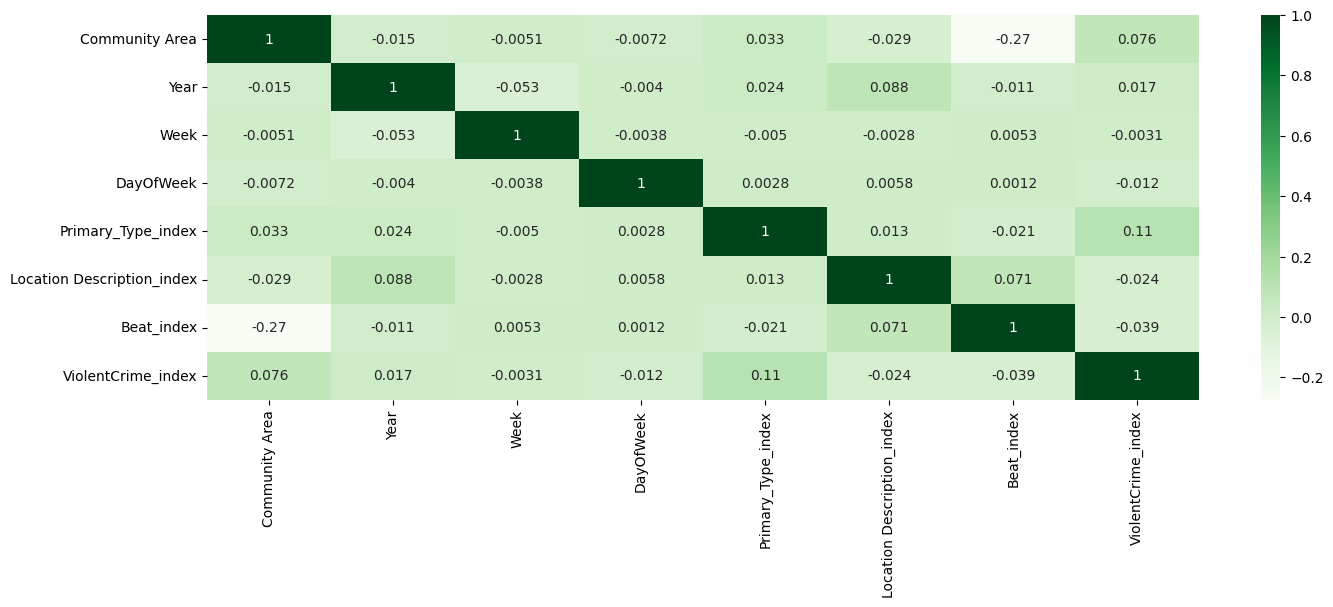

In [25]:
def run_correlaton_analysis(transformed_df,string_columns):
  t_df = transformed_df.drop(*string_columns)
  # convert to vector column first
  vector_col = "corr_features"
  assembler = VectorAssembler(inputCols= t_df.columns, outputCol=vector_col)
  df_vector = assembler.transform(t_df).select(vector_col)
  # get correlation matrix
  matrix = Correlation.corr(df_vector, vector_col)
  corr_matrix = matrix.collect()[0][0].toArray().tolist()
  corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = t_df.columns, index=t_df.columns)
  plt.figure(figsize=(16,5))
  sns.heatmap(corr_matrix_df,
              xticklabels=corr_matrix_df.columns.values,
              yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

run_correlaton_analysis(transformed_df.drop('Date'),string_columns)

As we can see from the plot that there are not strongly correlated features with ViolentCrime_index

In [26]:
LABEL_INPUT_COL  = 'ViolentCrime'
LABEL_OUTPUT_COL ='indexedLabel'
LABEL_CONV_INPUT_COL = 'prediction'
LABEL_CONV_OUTPUT_COL = 'predictedLabel'
FEATURES_OUTPUT_COL = 'features'
FEATURE_INDEXER_OUTPUT_COL ='indexedFeatures'
SPLIT_TYPE_YEAR = 'year'
SPLIT_TYPE_RATIO = 'ratio'
model_performances =[]

Indexing for labels
- IndexToString convert numerical labels to their original string labels after the model has made its predictions

In [27]:
labelIndexer = StringIndexer(inputCol=LABEL_INPUT_COL, outputCol=LABEL_OUTPUT_COL).fit(transformed_df)
labelConverter = IndexToString(inputCol=LABEL_CONV_INPUT_COL, outputCol=LABEL_CONV_OUTPUT_COL,
                              labels=labelIndexer.labels)

Train Test Data Spliting function based on year

In [28]:
def split_data_based_on_year(df):
  trainingData = df.filter("year(date)!=2023")
  testData = df.filter("year(date)=2023")
  return trainingData,testData

Train Test Data splitting function
- We will run try our model using both approaches
  - Splitting train and test data by year. We will keep the 2023 year data as test data and remaining as training data
  - Splitting train and test data by ratio

In [29]:
def get_train_test_split(df,split_type):
  if split_type == SPLIT_TYPE_YEAR:
    trainingData, testData = split_data_based_on_year(df)
  elif split_type ==SPLIT_TYPE_RATIO:
    # Splitting the data into a training and a testing set with a ratio of 0.9 to 0.1
    (trainingData, testData) = df.randomSplit([0.9, 0.1])
  else:
    raise Exception("Wrong split_type {}".format(split_type))
  print("Running the ML Flow For {} Type Split".format(split_type.title()))
  return trainingData, testData

Features creating function. To fit data into the vectors
- VectorAssembler will allow us to transform our input data in vector format.
- These feature vectores will be used to train the model

In [30]:
def create_features(cols,df):
  vector_assembler = VectorAssembler(inputCols = cols, outputCol=FEATURES_OUTPUT_COL)
  vector_assembled_df = vector_assembler.transform(df)
  featureIndexer =  VectorIndexer(inputCol=FEATURES_OUTPUT_COL, outputCol=FEATURE_INDEXER_OUTPUT_COL).fit(vector_assembled_df)
  return vector_assembled_df,featureIndexer

Model Training and prediction generating function

In [31]:
def train_model_and_get_predictions(classifier,featureIndexer,trainingData,testData):
  # Pipeline used to develop a machine learning pipeline that includes label indexing, feature indexing, classiying and label conversion
  pipeline = Pipeline(stages=[labelIndexer, featureIndexer, classifier,labelConverter])
  # Fit the pipeline with the training and transform the testing data
  model = pipeline.fit(trainingData)
  predictions = model.transform(testData)
  return predictions

Getting Prediction Scores.
- MulticlassClassificationEvaluator used to evaluate the performance of the models
- We will use both F-1 and Accuracy to evaluate the performance

In [32]:
def get_scores(predictions,model_name,feature_cols,split_type):
  evaluator = MulticlassClassificationEvaluator(
      labelCol=LABEL_OUTPUT_COL, predictionCol=LABEL_CONV_INPUT_COL, metricName="accuracy")

  evaluator2 = MulticlassClassificationEvaluator(
      labelCol=LABEL_OUTPUT_COL, predictionCol=LABEL_CONV_INPUT_COL, metricName="f1")
  accuracy = evaluator.evaluate(predictions)
  f1 = evaluator2.evaluate(predictions)
  print("{} accuracy = {}".format (model_name,accuracy))
  print("{} f1 score = {}".format(model_name,f1))
  model_performances.append({'f1':f1,'accuracy':accuracy,'model_name':model_name,'features':feature_cols,'split_type':split_type})

ML Flow function. This is the main function for ml flow.
- It runs feature generation function
- It runs the data splitting function
- It runs the model training and prediction generating function
- It gets the final evaluation scores

In [33]:
def run_ml_flow(classifier,feature_cols,df,split_type):
  vector_assembled_df,featureIndexer = create_features(feature_cols,df)
  trainingData,testData = get_train_test_split(vector_assembled_df,split_type)
  predictions = train_model_and_get_predictions(classifier,featureIndexer,trainingData,testData)
  model_name = type(classifier).__name__
  get_scores(predictions,model_name,feature_cols,split_type)

Model Hyperparameter Tuning Function
- CrossValidator (to perform cross-validation)
- ParamGridBuilder (to build a grid of hyperparameters)


**Tune hyperparameters using cross-validation to find the best-performing model by trying different combinations. This will allow us to optimize the model's performance and improve upon the previous results**

In [34]:
def hyper_param_tuning(classifier,feature_cols,df,split_type,paramGrid,num_folds=3):
  vector_assembled_df,featureIndexer = create_features(feature_cols,df)
  trainingData,testData = get_train_test_split(vector_assembled_df,split_type)
  pipeline = Pipeline(stages=[labelIndexer, featureIndexer, classifier,labelConverter])
  evaluator = MulticlassClassificationEvaluator( labelCol=LABEL_OUTPUT_COL, predictionCol=LABEL_CONV_INPUT_COL, metricName="f1")
  crossval = CrossValidator(estimator=pipeline,\
                         estimatorParamMaps=paramGrid,\
                         evaluator=evaluator,\
                         numFolds=num_folds)
  model = crossval.fit(trainingData)
  predictions = model.transform(testData)
  model_name = type(classifier).__name__
  get_scores(predictions,model_name,feature_cols,split_type)
  bestPipeline = model.bestModel
  bestModel = bestPipeline.stages[2]
  bestParams = bestModel.extractParamMap()
  print("\n".join("{}\t{}".format(k, v) for k, v in bestParams.items()))
  return bestModel

### **Features Performance Exploration**

#### **Prediction of Violent Crime using Time based features**

In [35]:
feature_time_cols=["Week",'DayOfWeek']
rf  = RandomForestClassifier(labelCol=LABEL_OUTPUT_COL,
                             featuresCol=FEATURE_INDEXER_OUTPUT_COL,
                             numTrees=100,impurity='gini', maxBins=128)


In [36]:
run_ml_flow(rf,feature_time_cols,transformed_df,SPLIT_TYPE_YEAR)

Running the ML Flow For Year Type Split
RandomForestClassifier accuracy = 0.5191734516916022
RandomForestClassifier f1 score = 0.48822883850942195


In [37]:
run_ml_flow(rf,feature_time_cols,transformed_df,SPLIT_TYPE_RATIO)

Running the ML Flow For Ratio Type Split
RandomForestClassifier accuracy = 0.5324333500797757
RandomForestClassifier f1 score = 0.49721204351205184


#### **Prediction of Violent Crime using Location based features**

In [38]:
feature_loc_cols=['Beat_index','Location Description_index','Community Area']
rf_loc = RandomForestClassifier(labelCol=LABEL_OUTPUT_COL, featuresCol=FEATURE_INDEXER_OUTPUT_COL, numTrees=10,impurity='gini',maxBins=320)

In [39]:
run_ml_flow(rf_loc,feature_loc_cols,transformed_df,SPLIT_TYPE_YEAR)

Running the ML Flow For Year Type Split
RandomForestClassifier accuracy = 0.5856265247935099
RandomForestClassifier f1 score = 0.5728935100659055


In [40]:
run_ml_flow(rf_loc,feature_loc_cols,transformed_df,SPLIT_TYPE_RATIO)

Running the ML Flow For Ratio Type Split
RandomForestClassifier accuracy = 0.5851412648506205
RandomForestClassifier f1 score = 0.5785276546163834


### **Model Training Using Final Features**

#### **Logistic Regression Model Performance**

In [41]:
final_feature_columns= feature_loc_cols + feature_time_cols
lr = LogisticRegression(labelCol=LABEL_OUTPUT_COL, featuresCol=FEATURE_INDEXER_OUTPUT_COL, maxIter=10)

In [42]:
run_ml_flow(lr,final_feature_columns,transformed_df,SPLIT_TYPE_YEAR)

Running the ML Flow For Year Type Split
LogisticRegression accuracy = 0.5300549660503806
LogisticRegression f1 score = 0.5135680839262629


In [43]:
run_ml_flow(lr,final_feature_columns,transformed_df,SPLIT_TYPE_RATIO)

Running the ML Flow For Ratio Type Split
LogisticRegression accuracy = 0.5388888659142946
LogisticRegression f1 score = 0.5292823841370364


#### **Random Forest Model Performance**

In [44]:
rf_all = RandomForestClassifier(labelCol=LABEL_OUTPUT_COL, featuresCol=FEATURE_INDEXER_OUTPUT_COL, numTrees=10,impurity='gini',maxBins=320)

In [45]:
run_ml_flow(rf_all,final_feature_columns,transformed_df,SPLIT_TYPE_YEAR)

Running the ML Flow For Year Type Split
RandomForestClassifier accuracy = 0.5744687105023368
RandomForestClassifier f1 score = 0.5575954773156885


In [46]:
run_ml_flow(rf_all,final_feature_columns,transformed_df,SPLIT_TYPE_RATIO)

Running the ML Flow For Ratio Type Split
RandomForestClassifier accuracy = 0.582914849187616
RandomForestClassifier f1 score = 0.5707507663467842


#### **Gradient Boost Model Performance**

The 'maxBins' parameter specifies the maximum number of bins that can be used for splitting on a feature. For categorical features, we need at least as many bins as there are categories.

The Gradient-Boosted Trees (GBT) algorithm in PySpark requires that the 'maxBins' parameter be at least as large as the number of values in the most populous categorical feature. In our case, there is a categorical feature with 304 distinct values, so we will need to increase 'maxBins' to be at least 304.

In [47]:
gbt = GBTClassifier(labelCol=LABEL_OUTPUT_COL, featuresCol=FEATURE_INDEXER_OUTPUT_COL, maxIter=2, maxBins=320)

In [48]:
run_ml_flow(gbt,final_feature_columns,transformed_df,SPLIT_TYPE_YEAR)

Running the ML Flow For Year Type Split
GBTClassifier accuracy = 0.6144322624261486
GBTClassifier f1 score = 0.6126165800018003


In [49]:
run_ml_flow(gbt,final_feature_columns,transformed_df,SPLIT_TYPE_RATIO)

Running the ML Flow For Ratio Type Split
GBTClassifier accuracy = 0.6106793486108952
GBTClassifier f1 score = 0.6065743627172233


### **Hyperparameter Tuning of Gradient Boost Model**

In [50]:
gbt_not_tuned = GBTClassifier(labelCol=LABEL_OUTPUT_COL, featuresCol=FEATURE_INDEXER_OUTPUT_COL)
paramGrid = ParamGridBuilder()\
            .addGrid(gbt_not_tuned.maxBins, [320]) \
            .addGrid(gbt_not_tuned.maxIter,[2,4])\
            .addGrid(gbt_not_tuned.stepSize,[0.1, 0.2])\
            .build()

In [51]:
gbt_tuned_yr = hyper_param_tuning(gbt_not_tuned,final_feature_columns,transformed_df,SPLIT_TYPE_YEAR,paramGrid)

Running the ML Flow For Year Type Split
GBTClassifier accuracy = 0.6143617177625584
GBTClassifier f1 score = 0.6137179677221274
GBTClassifier_8c86f8a072c5__cacheNodeIds	False
GBTClassifier_8c86f8a072c5__checkpointInterval	10
GBTClassifier_8c86f8a072c5__featureSubsetStrategy	all
GBTClassifier_8c86f8a072c5__featuresCol	indexedFeatures
GBTClassifier_8c86f8a072c5__impurity	variance
GBTClassifier_8c86f8a072c5__labelCol	indexedLabel
GBTClassifier_8c86f8a072c5__leafCol	
GBTClassifier_8c86f8a072c5__lossType	logistic
GBTClassifier_8c86f8a072c5__maxBins	320
GBTClassifier_8c86f8a072c5__maxDepth	5
GBTClassifier_8c86f8a072c5__maxIter	4
GBTClassifier_8c86f8a072c5__maxMemoryInMB	256
GBTClassifier_8c86f8a072c5__minInfoGain	0.0
GBTClassifier_8c86f8a072c5__minInstancesPerNode	1
GBTClassifier_8c86f8a072c5__minWeightFractionPerNode	0.0
GBTClassifier_8c86f8a072c5__predictionCol	prediction
GBTClassifier_8c86f8a072c5__probabilityCol	probability
GBTClassifier_8c86f8a072c5__rawPredictionCol	rawPrediction
GBTCl

In [52]:
gbt_tuned_rt = hyper_param_tuning(gbt_not_tuned,final_feature_columns,transformed_df,SPLIT_TYPE_RATIO,paramGrid)

Running the ML Flow For Ratio Type Split
GBTClassifier accuracy = 0.6119839456656468
GBTClassifier f1 score = 0.6107614819514917
GBTClassifier_8c86f8a072c5__cacheNodeIds	False
GBTClassifier_8c86f8a072c5__checkpointInterval	10
GBTClassifier_8c86f8a072c5__featureSubsetStrategy	all
GBTClassifier_8c86f8a072c5__featuresCol	indexedFeatures
GBTClassifier_8c86f8a072c5__impurity	variance
GBTClassifier_8c86f8a072c5__labelCol	indexedLabel
GBTClassifier_8c86f8a072c5__leafCol	
GBTClassifier_8c86f8a072c5__lossType	logistic
GBTClassifier_8c86f8a072c5__maxBins	320
GBTClassifier_8c86f8a072c5__maxDepth	5
GBTClassifier_8c86f8a072c5__maxIter	4
GBTClassifier_8c86f8a072c5__maxMemoryInMB	256
GBTClassifier_8c86f8a072c5__minInfoGain	0.0
GBTClassifier_8c86f8a072c5__minInstancesPerNode	1
GBTClassifier_8c86f8a072c5__minWeightFractionPerNode	0.0
GBTClassifier_8c86f8a072c5__predictionCol	prediction
GBTClassifier_8c86f8a072c5__probabilityCol	probability
GBTClassifier_8c86f8a072c5__rawPredictionCol	rawPrediction
GBTC

### Model Performance Comparison

In [312]:
def get_feature_type(feature):
  if feature == 'Week,DayOfWeek':
    return 'Time Features'
  elif feature == 'Beat_index,Location Description_index,Community Area':
    return 'Location Features'
  elif feature == 'Beat_index,Location Description_index,Community Area,Week,DayOfWeek':
    return 'Time+Location Features'
  else:
    raise Exception("Wrong feature type")

In [313]:
def get_model_short(model_name):
  if model_name =='RandomForestClassifier':
    return 'RFC'
  elif model_name =='LogisticRegression':
    return 'LR'
  elif model_name =='GBTClassifier':
    return 'GBT'
  else:
    raise Exception("Wrong Model type")

In [314]:
def show_model_performance(df, split_type):
  np.random_seed=43
  fig, ax = plt.subplots(figsize=(10, 7))
  ax.set_facecolor('black')
  fig.set_facecolor('black')
  df['label'] = df['model_label'] + " - " + df['feature_type'].astype(str)
  colors = ['red','green','cyan','orange','pink']
  for index, row in df.iterrows():
      label = row['label']
      color = colors[index]
      ax.scatter(row['f1'], row['accuracy'], marker='o', label=label,color=color)
      ax.text(row['f1'], row['accuracy'], '{0:.2g}'.format(row['f1']),size=14,color=color)
  ax.plot(df['f1'], df['accuracy'], linestyle='-')
  ax.set_xlabel('F1 Score',size=14)
  ax.set_ylabel('Accuracy',size=14)
  ax.set_title('Model Accuracy and F1 Score - For Split Type {}'.format(split_type.title()),color='#dddddd',size=15)
  ax.tick_params(axis='x', colors='#dddddd')
  ax.tick_params(axis='y', colors='#dddddd')
  ax.yaxis.label.set_color('#dddddd')
  ax.xaxis.label.set_color('#dddddd')
  ax.spines['bottom'].set_color('#dddddd')
  ax.spines['left'].set_color('#dddddd')
  ax.legend()
  plt.tight_layout()
  plt.show()


Transforming the model performance data for better visualization

In [315]:
model_performances_df = pd.DataFrame(model_performances)
model_performances_df['features'] = model_performances_df['features'].apply(lambda x: ",".join(x))
max_ids = model_performances_df.groupby(["model_name",'features',"split_type"])['f1'].idxmax().sort_values()
max_model_performances_df=model_performances_df.loc[max_ids].reset_index().drop('index',axis=1)
max_model_performances_df['feature_type'] = max_model_performances_df['features'].apply(get_feature_type)
max_model_performances_df['model_label'] = max_model_performances_df['model_name'].apply(get_model_short)

In [316]:
max_model_performances_df

,f1,accuracy,model_name,features,split_type,feature_type,model_label
0,0.488229,0.519173,RandomForestClassifier,"Week,DayOfWeek",year,Time Features,RFC
1,0.497212,0.532433,RandomForestClassifier,"Week,DayOfWeek",ratio,Time Features,RFC
2,0.572894,0.585627,RandomForestClassifier,"Beat_index,Location Description_index,Communit...",year,Location Features,RFC
3,0.578528,0.585141,RandomForestClassifier,"Beat_index,Location Description_index,Communit...",ratio,Location Features,RFC
4,0.513568,0.530055,LogisticRegression,"Beat_index,Location Description_index,Communit...",year,Time+Location Features,LR
5,0.529282,0.538889,LogisticRegression,"Beat_index,Location Description_index,Communit...",ratio,Time+Location Features,LR
6,0.557595,0.574469,RandomForestClassifier,"Beat_index,Location Description_index,Communit...",year,Time+Location Features,RFC
7,0.570751,0.582915,RandomForestClassifier,"Beat_index,Location Description_index,Communit...",ratio,Time+Location Features,RFC
8,0.613718,0.614362,GBTClassifier,"Beat_index,Location Description_index,Communit...",year,Time+Location Features,GBT
9,0.610761,0.611984,GBTClassifier,"Beat_index,Location Description_index,Communit...",ratio,Time+Location Features,GBT


In [317]:
max_model_performances_df_year = max_model_performances_df[max_model_performances_df['split_type']=='year'].reset_index()

In [318]:
max_model_performances_df_ratio = max_model_performances_df[max_model_performances_df['split_type']=='ratio'].reset_index()

Model Performance Visualiasation as per Year based Split Type Approach

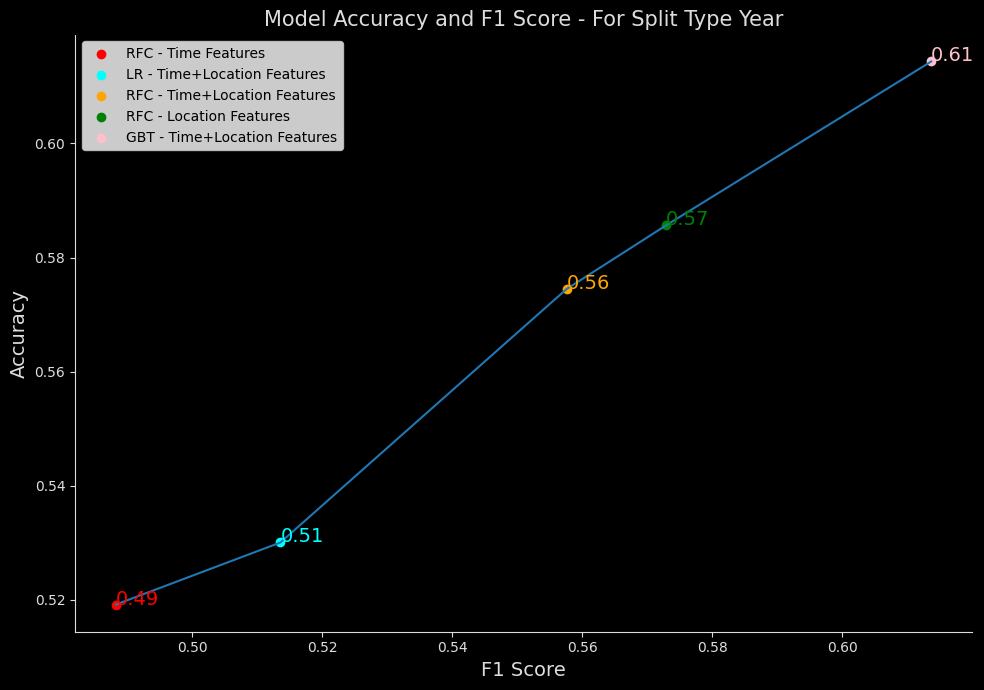

In [319]:
show_model_performance(max_model_performances_df_year.sort_values("f1"),SPLIT_TYPE_YEAR)

Model Performance Visualiasation as per Ratio Based Split Type Approach

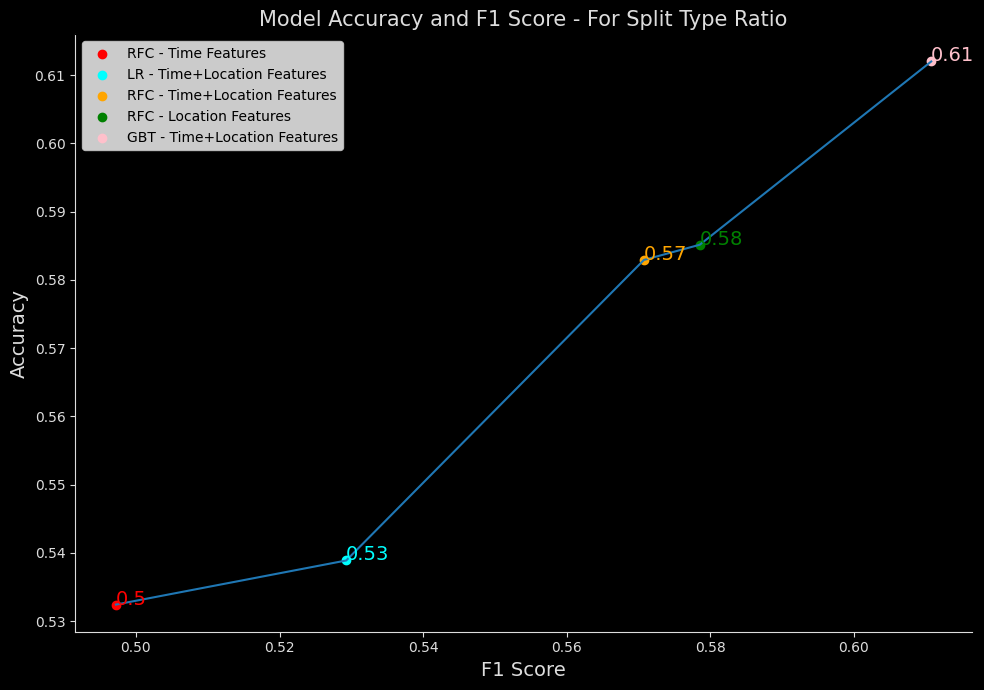

In [321]:
show_model_performance(max_model_performances_df_ratio.sort_values("f1"),SPLIT_TYPE_RATIO)